In [5]:
import os
import sys
current_dir = os.path.abspath(os.getcwd())
parent_dir = os.path.dirname(current_dir)
sys.path.append(os.path.join(parent_dir, 'scripts'))
import pandas as pd
from sklearn.model_selection  import train_test_split
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibrationDisplay

from feature_engineering import preprocessing
from Plots import Centiles_plot, ROC_plot, cumulative_centiles_plot

In [2]:
df = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')

In [3]:
X1, y1 = preprocessing (df, 'goalFlag')

In [4]:
X1_subset, _, y1_subset, _ = train_test_split(X1, y1, test_size=0.95, random_state=42)

In [5]:
parameters = {'kernel': ['rbf', 'poly'], 'C': [0.1, 0.5, 0.8], 'degree': [2, 3]}
svc = svm.SVC(probability= True)
clf1 = RandomizedSearchCV(svc, parameters, refit=True, n_iter=10, n_jobs=-1)
clf1.fit(X1_subset, y1_subset)

RandomizedSearchCV(estimator=SVC(probability=True), n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 0.8], 'degree': [2, 3],
                                        'kernel': ['rbf', 'poly']})

In [10]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [12]:
parameters = clf1.best_params_
clf_final = svm.SVC( **parameters, probability= True, cache_size=2000)
clf_final.fit(X1_train, y1_train)

SVC(C=0.8, cache_size=2000, degree=2, kernel='poly', probability=True)

In [1]:
print('hello')

hello


In [14]:
y1_score = clf_final.predict_proba(X1_test)

In [16]:
y1_score

array([[0.91205436, 0.08794564],
       [0.91108969, 0.08891031],
       [0.9108965 , 0.0891035 ],
       ...,
       [0.91133582, 0.08866418],
       [0.91075524, 0.08924476],
       [0.9130755 , 0.0869245 ]])

AUC metric : 0.5735231764062392


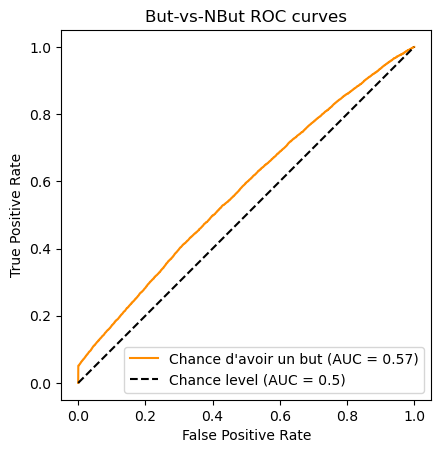

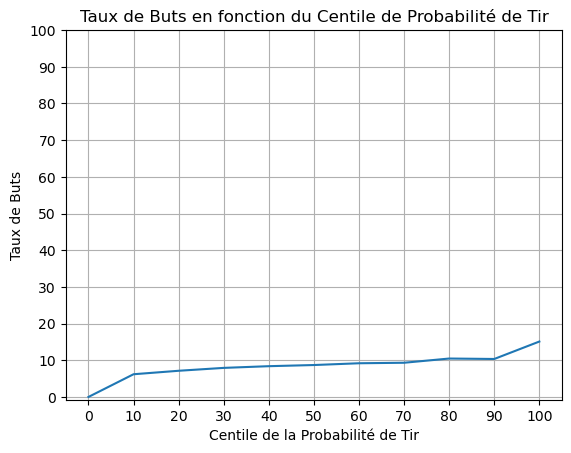

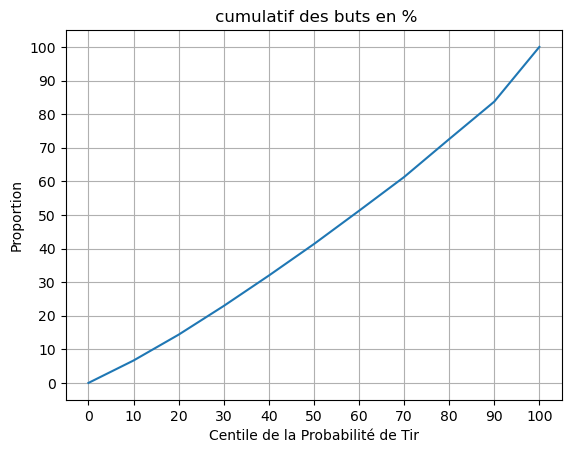

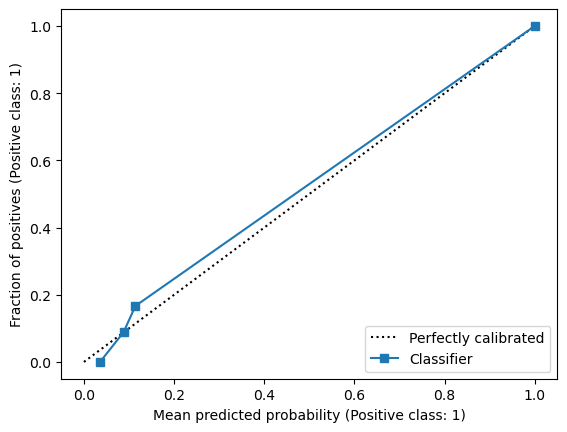

In [19]:
ROC_plot (y1_test, y1_score[:,1])

#Taux de buts
Centiles_plot(y1_test, y1_score[:,1])

# Cumule de buts
cumulative_centiles_plot(y1_test, y1_score[:,1])

# Courbe de calibration
CalibrationDisplay.from_predictions(y1_test, y1_score[:,1], n_bins=20)

In [ ]:
y2_score = clf2_final.predict_proba(X1_test)

In [8]:
def preprocessing(df):
    
    # On supprime les colonnes avec plus de 50% de NaN
    half_count = len(df) / 2
    df = df.dropna(thresh=half_count, axis=1)

    # Supprime les lignes avec des NaN
    df = df.dropna()

    # Colonnes One-Hot Encoding
    cols_to_encode = [
        'prd', 'team', 'shotCategory', 'shotBy', 'goalieName', 
        'visitorTeam', 'hostTeam', 'homeRinkSide', 
        'awayRinkSide', 'last_event_type'
    ]
    df = pd.get_dummies(df, columns=cols_to_encode)

    # Colonnes à binariser
    cols_to_binarize = ['noGoalie', 'rebond']
    for col in cols_to_binarize:
        df[col] = df[col].astype(int)

    # Supprime les colonnes redondantes
    cols_to_drop = ['gameId', 'evt_idx', 'prdTime']
    df = df.drop(cols_to_drop, axis=1)

    return df

In [9]:
df = pd.read_csv('../data/derivatives/dataframe_milestone_2.csv')
df['season'] = df['gameId'].apply(lambda x: str(x)[:4])
df = df[df['season'].isin(['2016', '2017', '2018'])]

features = [
    'gameId', 'evt_idx', 'prd', 'prdTime', 'team', 'goalFlag', 'shotCategory', 
    'coord_x', 'coord_y', 'shotBy', 'goalieName', 'noGoalie', 'teamStrength', 
    'visitorTeam', 'hostTeam', 'homeRinkSide', 'awayRinkSide', 'last_event_type', 
    'last_event_x', 'last_event_y', 'time_since_last_event', 
    'distance_from_last_event', 'game_seconds', 'shot_distance', 'shot_angle', 
    'rebond', 'changement_angle_tir', 'vitesse'
]

#On binarise les labels
df['goalFlag'] = df['goalFlag'].astype(int)
y = df['goalFlag']
features.remove('goalFlag')
X = df[features]

In [10]:
X_preprocessed = preprocessing(X)

print("X_preprocessed length:", X_preprocessed.shape[0])
print("y length:", y.shape[0])

# Régularise le nombres de lignes d'entrées x (après preprocessing) avec le nombre de sorties y
if X_preprocessed.shape[0] != y.shape[0]:
    y = y.loc[X_preprocessed.index]

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.3, random_state=42)

X_preprocessed length: 239474
y length: 253475


In [12]:

clf2_final = svm.SVC( C= 0.8, kernel= 'rbf', probability= True)
clf2_final.fit(X_train, y_train)